# FF model


In [80]:
!ls /storage/brno1-cerit/projects/msml/mg_neims_branch/MassGenie/data/NIST/NIST20_deriv/

NIST20_deriv.msp  NIST20_deriv_inchikeys.txt


## Settings

In [141]:
from pipeline_utils import get_galaxy_filename

base = "tmp"
dataset = "nist"
kind = "in_database"


wv_path = f"gas2vec/{kind}.model"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"../data/{dataset}/{kind}/test.msp"

data_nist_rcx1_only_path = "../data/nist/nist_rcx1_only/train.msp"
data_nist_rcx2_only_path = "../data/nist/nist_rcx2_only/train.msp"

data_rcx1_nonist_path = "../data/nist/rcx1_no_nist/train.msp"
data_rcx2_nonist_path = "../data/nist/rcx2_no_nist/train.msp"


data_rcx2_path = "../data/rcx_gc-orbitrap_metabolites_20210817.msp"
data_rcx1_path = "../data/recetox_gc-ei_ms_20201028.msp"



data_derivatized_path = "/storage/brno1-cerit/projects/msml/mg_neims_branch/MassGenie/data/NIST/NIST20_deriv/NIST20_deriv.msp"

data_realtest_path = get_galaxy_filename('Aplcms12', base, ["enh", "pred"])

%load_ext autoreload
%autoreload 2

import sys; sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data loading

In [142]:
# from matchms.importing import load_from_msp

from matchms.importing import load_from_msp
from utils.helpers import get_mz_vector, get_his_size
from utils.data_utils import spectrum_processing
from utils.data_utils import FixedSizeDS
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F

# only for visual 
from spec2vec import SpectrumDocument
from utils.data_utils import BasicCoder


In [143]:
def load_process_documents(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None, n_required_peaks=1) for s in load_from_msp(path, metadata_harmonization=False)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]
    return documents, spectrums

# documents_train = load_process_documents(data_train_path)
# documents_val = load_process_documents(data_val_path)
documents_supertest, spectrums_supertest = load_process_documents(data_realtest_path)

documents_rcx1, spectrums_rcx1 = load_process_documents(data_rcx1_path)
documents_rcx2, spectrums_rcx2 = load_process_documents(data_rcx2_path)

documents_nonist_rcx1, spectrums_nonist_rcx1 = load_process_documents(data_rcx1_nonist_path)
documents_nonist_rcx2, spectrums_nonist_rcx2 = load_process_documents(data_rcx2_nonist_path)

documents_nist_rcx1_only, spectrums_nist_rcx1_only = load_process_documents(data_nist_rcx1_only_path)
documents_nist_rcx2_only, spectrums_nist_rcx2_only = load_process_documents(data_nist_rcx2_only_path)

documents_derivatized, spectrums_derivatized = load_process_documents(data_derivatized_path)

In [144]:
# load original test set, take only derivatized compounds
derivatized_inchis = set([spec.metadata["inchikey"] for spec in spectrums_derivatized])

_, spectrums_test = load_process_documents(data_test_path)
spectrums_derivatized_test = [spec for spec in spectrums_test if spec.metadata["inchikey"] in derivatized_inchis]
spectrums_non_derivatized_test = [spec for spec in spectrums_test if spec.metadata["inchikey"] not in derivatized_inchis]

In [145]:
# get rcx compound present in NIST
nist_rcx1_only_inchis = set([spec.metadata["inchikey"] for spec in spectrums_nist_rcx1_only])
spectrums_rcx1_only_nist = [spec for spec in spectrums_rcx1 if spec.metadata["inchikey"] in nist_rcx1_only_inchis]

nist_rcx2_only_inchis = set([spec.metadata["inchikey"] for spec in spectrums_nist_rcx2_only])
spectrums_rcx2_only_nist = [spec for spec in spectrums_rcx2 if spec.metadata["inchikey"] in nist_rcx2_only_inchis]



In [149]:
len(spectrums_derivatized_test), len(spectrums_non_derivatized_test) 

(1152, 21458)

In [150]:
len(spectrums_rcx1), len(spectrums_nonist_rcx1), len(spectrums_nist_rcx1_only)

(386, 62, 1061)

In [151]:
len(spectrums_rcx2), len(spectrums_nonist_rcx2), len(spectrums_nist_rcx2_only)

(265, 155, 288)

In [152]:

datasets = {
    "fixed_train": FixedSizeDS(spectrums_supertest),
    "fixed_derivatized_nist_test": FixedSizeDS(spectrums_derivatized_test),
    "fixed_nonderivatized_nist_test": FixedSizeDS(spectrums_non_derivatized_test),
    "fixed_libtest1": FixedSizeDS(spectrums_rcx1),
    "fixed_libtest2": FixedSizeDS(spectrums_rcx2),
    "fixed_supertest": FixedSizeDS(spectrums_supertest),
    "fixed_derivatized_nist_all": FixedSizeDS(spectrums_derivatized),
    "fixed_nist_rcx1_only": FixedSizeDS(spectrums_nist_rcx1_only),
    "fixed_nist_rcx2_only": FixedSizeDS(spectrums_nist_rcx2_only),
    "fixed_rcx1_nonist": FixedSizeDS(spectrums_nonist_rcx1),
    "fixed_rcx2_nonist": FixedSizeDS(spectrums_nonist_rcx2),
    "fixed_rcx1_nist_only": FixedSizeDS(spectrums_rcx1_only_nist),
    "fixed_rcx2_nist_only": FixedSizeDS(spectrums_rcx2_only_nist),
    
    
}

dataloaders = {
}

In [63]:
datasets["fixed_train"][0][1].sum()

tensor(0.)

## Models definition

In [64]:
class Linear(nn.Module):
    def __init__(self, max_mz=1001):
        super(Linear, self).__init__()
        self.in_features = max_mz
        self.out_features = max_mz
    
        self.linear = nn.Linear(self.in_features, self.out_features)
        self.sigm = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear(x)
        return self.sigm(x)
    
class MLP(nn.Module):
    def __init__(self, max_mz=1001, hidden_layers=(2000,)):
        super(MLP, self).__init__()
        self.in_features = max_mz
        self.out_features = max_mz
        
        assert len(hidden_layers) != 0
        self.relu = nn.ReLU()        
        layers = [nn.Linear(self.in_features, hidden_layers[0])]
        
        for i in range(len(hidden_layers)-1):
            layers.append(self.relu)
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            
        
        self.layers = nn.Sequential(*layers)
        self.linear = nn.Linear(hidden_layers[-1], self.out_features)
        self.sigm = nn.Sigmoid()

        
    def forward(self, x):
        x = self.layers(x)
        x= self.relu(x)
        x = self.linear(x)
        return self.sigm(x)
    

In [65]:
linear = Linear(datasets["fixed_train"].max_mz)
mlp_1 = MLP(datasets["fixed_train"].max_mz, (1000,))
mlp_2 = MLP(datasets["fixed_train"].max_mz, (1000,1000))
mlp_3 = MLP(datasets["fixed_train"].max_mz, (1000,1000, 1000))
mlp_1s = MLP(datasets["fixed_train"].max_mz, (500,))
mlp_2s = MLP(datasets["fixed_train"].max_mz, (500,500))
mlp_3s = MLP(datasets["fixed_train"].max_mz, (500,500, 500))



In [66]:
# discver whether to use GPU or not
use_cuda = False#torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)


cpu


## Prediction

In [67]:
class PredictorFF():
    def __init__(self,model, max_mz=1001, threshold=.5):
        self.model = model
        self.max_mz= max_mz
        self.threshold = threshold
        
    @classmethod
    def from_file(cls, file, device="cpu", max_mz=1001, threshold=.5):
        model = torch.load(file,  map_location=torch.device(device)) 
        return cls(model, max_mz=max_mz, threshold=threshold)
   

    def __call__(self, X):
        with torch.no_grad():
            return self.model(X)
    
    def predict_random_all(self, ds, probs, cum_level=.95, filtered=True, \
                           device="cpu", **kwargs):
        # reset rng before each prediction to have comparable results
        self.rng = np.random.default_rng(42)

        spectrums = ds.spectrums
        m_pred_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        m_y_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        some_pred_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        
        for i, spec in enumerate(spectrums):
            vect = get_mz_vector(spec, self.max_mz)
            
            mat = np.zeros(shape=(len(probs),vect.shape[0]), dtype=np.float32)

            # descending = np.argsort(spec.peaks.intensities)[::-1]
            
            # argsorted = np.argsort(vect)[::-1]
            his_size = get_his_size(spec, cum_level)
            his_ind = np.argpartition(vect, -his_size)[-his_size:]
       
            for m, p in enumerate(probs):
                
                ## cripple vector
                mat[m] = vect.copy()
                
                # if too little peaks are present in the high intensity section, simply cut out top m most intense peaks 
                # cut_out_kths = self.rng.choice(max(n_peaks_considered, m), size=m, replace=False)
                #cut_out_kths = self.rng.choice(n_peaks_considered, size=min(m, n_peaks_considered), replace=False)
                
                # his_ind = np.argsort(mat[m])[::-1][:his_size]
                mask_missing = self.rng.uniform(0,1, self.max_mz) < p
                
                #cut_out_indices = argsorted[his_ind[mask_missing]] 
                
                mat[m][mask_missing] = 0
                
                his_mask = np.zeros_like(vect) == 1
                his_mask[his_ind] = True
                
                m_y_per_p[m][i] = np.where(mask_missing & his_mask)[0]
                
            # get predictions
            with torch.no_grad():
                mat_ = torch.from_numpy(mat).to(device)
                pred = self.model(mat_)
                pred = pred.cpu().numpy()    
            
            if filtered:
                pred[mat!=0] = 0
                
            # get best peaks above threshold (except the given ones)    
            for m in range(len(probs)):
                some = np.where(pred[m] > self.threshold)[0]
                some_pred_per_p[m][i] = some
            
            # get best m peaks (except the given ones)
            for m in range(len(probs)):
                next_m = np.argsort(pred[m])[::-1][:len(m_y_per_p[m][i])]
                m_pred_per_p[m][i] = next_m     
            
        return some_pred_per_p, m_pred_per_p, m_y_per_p



# MLP

In [68]:
P_FOLDER = f"predictions/{kind}"
probs = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]

In [69]:
predictors = { 
            "mlp_1_.8": PredictorFF.from_file(f"../models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.8),
            "mlp_1_.5": PredictorFF.from_file(f"../models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.5),
            "mlp_1_.3": PredictorFF.from_file(f"../models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.3),
            "mlp_1_.1": PredictorFF.from_file(f"../models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.1),
            "mlp_2_.8": PredictorFF.from_file(f"../models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.8),
            "mlp_2_.5": PredictorFF.from_file(f"../models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.5),
            "mlp_2_.3": PredictorFF.from_file(f"../models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.3),
            "mlp_2_.1": PredictorFF.from_file(f"../models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.1),
            "mlp_3_.8": PredictorFF.from_file(f"../models/{kind}/mlp_3", max_mz=1001, device=device, threshold=.8),
            "mlp_3_.5": PredictorFF.from_file(f"../models/{kind}/mlp_3", max_mz=1001, device=device, threshold=.5),
            "mlp_3_.3": PredictorFF.from_file(f"../models/{kind}/mlp_3", max_mz=1001, device=device, threshold=.3),
            "mlp_3_.1": PredictorFF.from_file(f"../models/{kind}/mlp_3", max_mz=1001, device=device, threshold=.1),
            "mlp_2s_.8": PredictorFF.from_file(f"../models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.8),
            "mlp_2s_.5": PredictorFF.from_file(f"../models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.5),
            "mlp_2s_.3": PredictorFF.from_file(f"../models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.3),
            "mlp_2s_.1": PredictorFF.from_file(f"../models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.1)


}


In [70]:
P_FOLDER

'predictions/in_database'

In [71]:
best_p_name = "mlp_2_.1"

## Simulated test on rcx libraries

In [72]:
from utils.model_evaluation import calc_predictions_random, load_predictions_random, model_selection_random
from utils.visual_utils import plot_scores

In [15]:

%%time
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_libtest1", P_FOLDER, batch_size=512, device=device, verbose=True)
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_libtest2", P_FOLDER, batch_size=512, device=device, verbose=True)

mlp_2_.1


/storage/brno2/home/xstary1/brno6/.local-Pytorch-21.SIF/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


mlp_2_.1
CPU times: user 2.8 s, sys: 19.5 ms, total: 2.82 s
Wall time: 2.87 s


mlp_2_.1


../utils/metrics.py:228: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
../utils/metrics.py:230: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
../utils/metrics.py:231: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


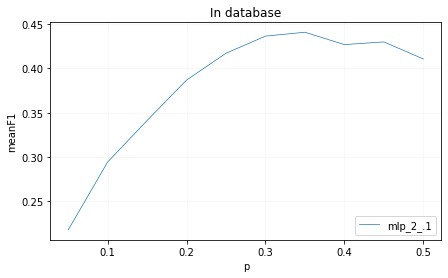

mlp_2_.1


../utils/metrics.py:228: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
../utils/metrics.py:230: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
../utils/metrics.py:231: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


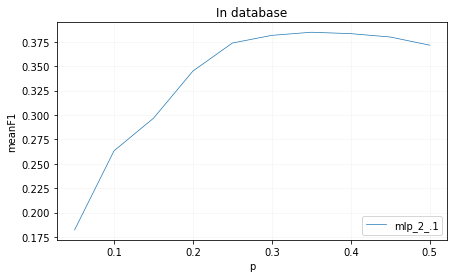

In [113]:
orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
_, scores_test = model_selection_random(P_FOLDER, "fixed_libtest1", predictors={best_p_name: predictors[best_p_name]})
plot_scores(scores_test, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1")


orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
_, scores_test = model_selection_random(P_FOLDER, "fixed_libtest2", predictors={best_p_name: predictors[best_p_name]})
plot_scores(scores_test, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1")

## Simulated test on RCX compounds present in NIST

In [153]:
%%time
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_rcx1_nist_only", P_FOLDER, batch_size=512, device=device, verbose=True)
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_rcx2_nist_only", P_FOLDER, batch_size=512, device=device, verbose=True)

mlp_2_.1


/storage/brno2/home/xstary1/brno6/.local-Pytorch-21.SIF/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


mlp_2_.1
CPU times: user 2.34 s, sys: 3.86 ms, total: 2.34 s
Wall time: 2.58 s


mlp_2_.1


../utils/metrics.py:228: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
../utils/metrics.py:230: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
../utils/metrics.py:231: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


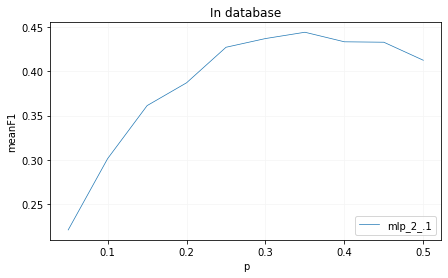

mlp_2_.1


../utils/metrics.py:228: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
../utils/metrics.py:230: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
../utils/metrics.py:231: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


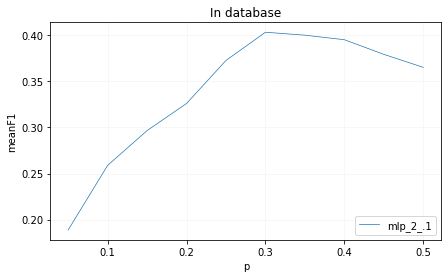

In [154]:
orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
_, scores_test = model_selection_random(P_FOLDER, "fixed_rcx1_nist_only", predictors={best_p_name: predictors[best_p_name]})
plot_scores(scores_test, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1")

orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
_, scores_test = model_selection_random(P_FOLDER, "fixed_rcx2_nist_only", predictors={best_p_name: predictors[best_p_name]})
plot_scores(scores_test, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1")

## Simulated test on NIST compounds present in the rcx libraries

In [114]:
%%time
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_nist_rcx1_only", P_FOLDER, batch_size=512, device=device, verbose=True)
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_nist_rcx2_only", P_FOLDER, batch_size=512, device=device, verbose=True)

mlp_2_.1


/storage/brno2/home/xstary1/brno6/.local-Pytorch-21.SIF/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


mlp_2_.1
CPU times: user 7.08 s, sys: 23.2 ms, total: 7.11 s
Wall time: 7.59 s


mlp_2_.1


../utils/metrics.py:228: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
../utils/metrics.py:230: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
../utils/metrics.py:231: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


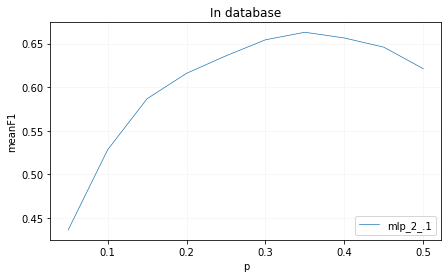

mlp_2_.1


../utils/metrics.py:228: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
../utils/metrics.py:230: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
../utils/metrics.py:231: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


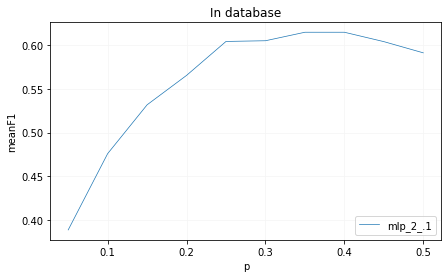

In [115]:
orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
_, scores_test = model_selection_random(P_FOLDER, "fixed_nist_rcx1_only", predictors={best_p_name: predictors[best_p_name]})
plot_scores(scores_test, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1")

orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
_, scores_test = model_selection_random(P_FOLDER, "fixed_nist_rcx2_only", predictors={best_p_name: predictors[best_p_name]})
plot_scores(scores_test, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1")

## Simulated test on purely derivatized compounds

In [73]:
%%time
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_derivatized_nist_all", P_FOLDER, batch_size=512, device=device, verbose=True)

mlp_2_.1


/storage/brno2/home/xstary1/brno6/.local-Pytorch-21.SIF/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


CPU times: user 44.6 s, sys: 546 ms, total: 45.2 s
Wall time: 48.2 s


mlp_2_.1


../utils/metrics.py:228: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
../utils/metrics.py:230: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
../utils/metrics.py:231: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


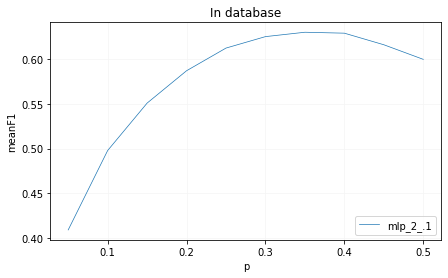

In [74]:
orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
_, scores_test = model_selection_random(P_FOLDER, "fixed_derivatized_nist_all", predictors={best_p_name: predictors[best_p_name]})
plot_scores(scores_test, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1")

## Simulated test on purely derivatized compounds present in original test set

In [75]:
%%time
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_derivatized_nist_test", P_FOLDER, batch_size=512, device=device, verbose=True)
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_nonderivatized_nist_test", P_FOLDER, batch_size=512, device=device, verbose=True)

mlp_2_.1


/storage/brno2/home/xstary1/brno6/.local-Pytorch-21.SIF/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


mlp_2_.1
CPU times: user 1min 57s, sys: 1.37 s, total: 1min 58s
Wall time: 2min


mlp_2_.1


../utils/metrics.py:228: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
../utils/metrics.py:230: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
../utils/metrics.py:231: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


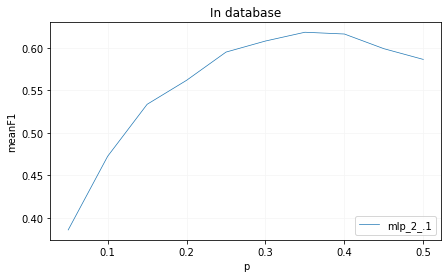

In [76]:
orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
_, scores_test = model_selection_random(P_FOLDER, "fixed_derivatized_nist_test", predictors={best_p_name: predictors[best_p_name]})
plot_scores(scores_test, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1")

mlp_2_.1


../utils/metrics.py:228: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
../utils/metrics.py:230: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
../utils/metrics.py:231: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


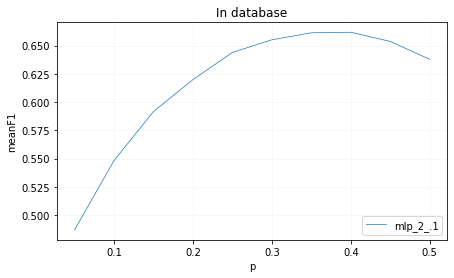

In [77]:
orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
_, scores_test = model_selection_random(P_FOLDER, "fixed_nonderivatized_nist_test", predictors={best_p_name: predictors[best_p_name]})
plot_scores(scores_test, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1")

## Supertest

In [18]:
ds = datasets["fixed_supertest"]
batch_size = 1
predictor = predictors[best_p_name]

In [19]:
some_pred_per_p, _, _ = predictor.predict_random_all(ds,[0])
preds = some_pred_per_p[0]

In [20]:
from utils.prediction_utils import enhance_spectra, predict_spectra
        
enhanced_spectra = [*enhance_spectra(spectrums_supertest, preds, 5)]
predicted_spectra = [*predict_spectra(spectrums_supertest, preds, 5)]


In [21]:
from matchms.exporting import save_as_msp

In [22]:
# save_as_msp(enhanced_spectra, f"{data_realtest_path[:-4]}_enh_{best_p_name}.msp")
save_as_msp(predicted_spectra, f"{data_realtest_path[:-4]}_pred_{best_p_name}.msp")

# put(f"{data_realtest_path[:-4]}_enh_{best_p_name}.msp")
# put(f"{data_realtest_path[:-4]}_pred_{best_p_name}.msp")

In [23]:
some_pred_per_p

[[array([81]),
  array([ 72,  88, 144, 189, 331, 333]),
  array([ 81,  86,  91,  93, 106, 281]),
  array([104, 126, 155, 157, 207, 280]),
  array([ 81,  95,  97, 157, 173, 242]),
  array([279]),
  array([ 95, 126, 192]),
  array([155, 156, 212, 241, 332]),
  array([ 78,  91,  93, 107, 122, 174, 198, 249, 251, 280]),
  array([111, 112]),
  array([], dtype=int64),
  array([ 93, 147]),
  array([ 86, 149, 167, 168]),
  array([112, 167]),
  array([101, 125]),
  array([ 77,  90, 105, 121, 136, 144, 175, 188, 191, 192, 221]),
  array([148, 150, 191]),
  array([117, 118, 149]),
  array([119]),
  array([131, 160, 189]),
  array([ 77,  84, 106, 242, 262]),
  array([ 73, 166, 174, 202]),
  array([201, 216, 217]),
  array([ 51,  78, 105, 183, 186, 187, 288]),
  array([ 91, 119, 183, 203, 230]),
  array([ 51, 186]),
  array([229]),
  array([ 93, 117, 166]),
  array([217]),
  array([113, 234, 235, 307]),
  array([113, 118, 146, 161, 172]),
  array([], dtype=int64),
  array([158, 230, 353]),
  array(

In [24]:
assert False

AssertionError: 

In [ ]:
def loader_gen(ds, batch_size):
    
    for i in range((len(ds)//batch_size)):
        n_sam = batch_size #if i*batch_size < len(ds) else len(ds) % batch_size
        batch = torch.zeros(batch_size, 1001), torch.zeros(batch_size, 1001)
        for j in range(n_sam):
            batch[0][j] = ds[i*batch_size+j][0]
            batch[1][j] = ds[i*batch_size+j][1]
        yield batch
            
    n_sam = len(ds)% batch_size
            
    batch = torch.zeros(batch_size, 1001), torch.zeros(batch_size, 1001)    
    for j in range((len(ds) % batch_size)):
        batch[0][j] = ds[(i+1)*batch_size+j][0]
        batch[1][j] = ds[(i+1)*batch_size+j][1]
        yield batch
            
loader = loader_gen(ds, batch_size)
len_loader = len(ds)//batch_size + 1


X_intens = [np.sort(s.peaks.intensities)[::-1] for s in ds.spectrums]



In [ ]:
len(ds)

In [ ]:
from tqdm import tqdm
preds = []
for b, X_dict_batch_ in enumerate(tqdm(loader)):
    #print(X_dict_batch_)
#     X_dict_batch = {"input_ids": torch.atleast_2d(X_dict_batch_["input_ids"][X_dict_batch_["attention_mask"] == 1])}
    #print(X_dict_batch)
    pred = predictor.predict_l_next(X_dict_batch, l=10)[0]
#     pred = predictor.coder.index2mz[pred]
    preds.append(pred)

In [ ]:
len(preds)

In [ ]:
hugg_ds.ref_docs[0]

In [ ]:
spectrums_supertest[1].metadata

In [ ]:
spectrums_supertest[0].peaks.mz